# Stocks Analysis & Reporting Automation

In [2]:
# Uncomment the following lines to install the required packages
# %pip install pandas sqlalchemy mysqlclient
# %pip install mysql-connector-python
# %pip install seaborn

Note: you may need to restart the kernel to use updated packages.
  Using cached mysql_connector_python-8.3.0-cp311-cp311-win_amd64.whl.metadata (2.0 kB)
   ---------------------------------------- 0.0/15.4 MB ? eta -:--:--
   ---------------------------------------- 0.1/15.4 MB 2.2 MB/s eta 0:00:07
    --------------------------------------- 0.2/15.4 MB 2.2 MB/s eta 0:00:07
    --------------------------------------- 0.3/15.4 MB 2.4 MB/s eta 0:00:07
   - -------------------------------------- 0.4/15.4 MB 2.2 MB/s eta 0:00:07
   - -------------------------------------- 0.5/15.4 MB 2.2 MB/s eta 0:00:07
   - -------------------------------------- 0.6/15.4 MB 2.3 MB/s eta 0:00:07
   - -------------------------------------- 0.7/15.4 MB 2.3 MB/s eta 0:00:07
   -- ------------------------------------- 0.8/15.4 MB 2.3 MB/s eta 0:00:07
   -- ------------------------------------- 1.0/15.4 MB 2.3 MB/s eta 0:00:07
   -- ------------------------------------- 1.0/15.4 MB 2.3 MB/s eta 0:00:07
   ---

In [4]:
# standard libraries
import pandas as pd
import numpy as np
# database connection
import os
from sqlalchemy import create_engine
# data visualization and plots creation
import seaborn as sns
import matplotlib.pyplot as plt

### I. Read CSV and calculate daily percentage change for each stock

In [5]:
# Method to generate initial DataFrame from CSV file
def load_and_prepare_data(csv_path):
    """
    Load data from CSV, clean, and prepare for analysis.

    Parameters:
    csv_path (str): The path to the CSV file containing the stock data.

    Returns:
    pandas.DataFrame: A DataFrame with the daily percentage change of the closing price for each stock.
    """
    try:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_path)
        # Remove any duplicates based on 'Date' and 'Symbol' before pivoting
        df.drop_duplicates(subset=['Date', 'Symbol'], inplace=True)
        # Ensure no NaN values in 'Close' before calculating 'Percent Change'
        df.dropna(subset=['Close'], inplace=True)
        # Sort by 'Date' and 'Symbol' to ensure chronological order for percent change calculation
        df.sort_values(by=['Date', 'Symbol'], inplace=True, ascending=[True, True])
        # Calculate the daily percentage change of the closing price for each stock
        df['Percent Change'] = df.groupby('Symbol')['Close'].pct_change() * 100
        print("Dataframe loaded and prepared for analysis")
        return df

    except Exception as e:
        print(f"Error loading dataframe from csv file {e}")
        
## example usage
# csv_path = 'stocks.csv'
# df = load_and_prepare_data(csv_path)
# df.head()


### II. Reports generation for stocks analysis

In [6]:
# Method to generate Biggest Move report
def generate_reports(df):
    """
    Generate reports and visualizations from the stock data.

    Args:
        df (pandas.DataFrame): The cleaned dataframe from csv file.

    Returns:
        pandas.DataFrame: Two DataFrames containing the Biggest Move Report and Average Percent Change Report
    """
    try: 
        # Biggest Move Report
        # Identify the stock with the biggest absolute percentage change for each day
        df['Abs Percent Change'] = df['Percent Change'].abs()
        # Get the index of max absolute percentage change for each day
        idx = df.groupby('Date')['Abs Percent Change'].idxmax()
        # Remove NaN values from idx to ensure it only contains valid indices
        idx = idx.dropna()
        # Use the index to locate the rows in df
        biggest_move_report = df.loc[idx, ['Date', 'Symbol', 'Abs Percent Change']]

        # Average Percent Change Report
        avg_percent_change_per_stock = df.groupby('Symbol')['Percent Change'].mean().reset_index()
        avg_percent_change_per_stock.columns = ['Symbol', 'Avg Percent Change']
        
        return biggest_move_report, avg_percent_change_per_stock
    
    except KeyError as e:
        print(f"KeyError occurred: {e}")
    except ValueError as e:
        print(f"ValueError occurred: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        # Optionally, return empty DataFrames or None in case of error
        return pd.DataFrame(), pd.DataFrame()
    
## example usage
# csv_path = 'stocks.csv'
# df = load_and_prepare_data(csv_path)
# print(generate_reports(df))

### III. Save Reports to MySQL (Optional)

In [5]:
# Uncomment the following lines to save reports to MySQL database

# def save_to_database(df_list, table_names, database_credentials):
#     """
#     Saves a list of DataFrames to a MySQL database using provided credentials and table names.

#     Args:
#         df_list (list of pandas.DataFrame): List of DataFrames to save.
#         table_names (list of str): Corresponding list of table names for the DataFrames.
#         database_credentials (dict): Dictionary with database connection details.
#     """
#     try:
#         # Construct the MySQL connection string
#         database_url = f"mysql+mysqlconnector://{database_credentials['user']}:" \
#                         f"{database_credentials['password']}@{database_credentials['host']}:" \
#                         f"{database_credentials['port']}/{database_credentials['dbname']}"
        
#         # Create database engine
#         engine = create_engine(database_url)

#         # Save each DataFrame to its respective table
#         for df, table_name in zip(df_list, table_names):
#             df.to_sql(table_name, engine, if_exists='replace', index=False)
        
#         print("DataFrames saved to MySQL database successfully.")

#     except Exception as e:
#         print(f"Error saving DataFrames to database: {e}")

# # Example usage
# database_credentials = {
#     'user': 'root',
#     'password': 'password',
#     'host': 'localhost',
#     'port': '3306',
#     'dbname': 'stock_analysis'
# }

# # Assume 'load_and_prepare_data' and 'generate_reports' are defined and return the necessary DataFrames
# csv_path = 'stocks.csv'
# df = load_and_prepare_data(csv_path)
# biggest_move_report, avg_percent_change_per_stock = generate_reports(df)
# df_list = [biggest_move_report, avg_percent_change_per_stock]
# table_names = ['biggest_move_report', 'avg_percent_change_per_stock']

# # Call the optimized save_to_database function
# save_to_database(df_list, table_names, database_credentials)

### III. Save Reports to SQLite

In [7]:
def save_to_database(df_list, table_names, db_path):
    """
    Saves a list of DataFrames to an SQLite database using provided file path.

    Args:
        df_list (list of pandas.DataFrame): List of DataFrames to save.
        table_names (list of str): Corresponding list of table names for the DataFrames.
        db_path (str): Path to the SQLite database file.
    """
    try:
        # Construct the SQLite connection string
        database_url = f"sqlite:///{db_path}"
        
        # Create database engine
        engine = create_engine(database_url)

        # Save each DataFrame to its respective table
        for df, table_name in zip(df_list, table_names):
            df.to_sql(table_name, engine, if_exists='replace', index=False)
        
        print("DataFrames saved to SQLite database successfully.")
    
    except Exception as e:
        print(f"Error saving DataFrames to database: {e}")

## Example usage
# csv_path = 'stocks.csv'  # CSV file relative path
# db_path = 'stock_analysis.db'  # SQLite database relative file path
# df = load_and_prepare_data(csv_path)
# biggest_move_report, avg_percent_change_per_stock = generate_reports(df)
# df_list = [biggest_move_report, avg_percent_change_per_stock]
# table_names = ['biggest_move_report', 'avg_percent_change_per_stock']

# # Call the revised save_to_database function for SQLite
# save_to_database(df_list, table_names, db_path)


#### V. SQL script to get the number of top performing days for each stock:

```sql
SELECT 
	a.Symbol AS `Symbol`,
	IFNULL(b.`Top Performing Days`, 0) AS `Top Performing Days`
FROM 
	(SELECT Symbol FROM avg_percent_change_per_stock) a
LEFT JOIN 
	(SELECT Symbol, COUNT(*) AS `Top Performing Days` FROM biggest_move_report GROUP BY Symbol) b
ON a.Symbol = b.Symbol
ORDER BY `Top Performing Days` DESC
```

#### VI. Create Correlation Matrix

In [8]:
def visualize_stock_correlation(df, output_path):
    """
    Visualizes the correlation matrix of daily returns for each stock.

    Parameters:
    df (DataFrame): The input DataFrame containing stock data.
    output_path (str): The path to save the output image file.


    Returns:
    None
    """

    # Pivot the DataFrame to get daily returns for each stock
    daily_returns = df.pivot(index='Date', columns='Symbol', values='Percent Change')
    # Calculate the correlation matrix
    correlation_matrix = daily_returns.corr()
    # Visualizing the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Stock Correlation Matrix')
    # (Optional) Save the figure as an image file
    plt.savefig(output_path)
    print("Correlation matrix visualization saved as an image file: ", output_path)

    # Display the plot
    plt.show()

# # example usage
# csv_path = 'stocks.csv'
# df = load_and_prepare_data(csv_path)
# visualize_stock_correlation(df,'correlation_matrix.png')

Dataframe loaded and prepared for analysis
DataFrames saved to SQLite database successfully.


C:\Users\gigiv\AppData\Local\Temp\ipykernel_4140\57840276.py:17: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  idx = df.groupby('Date')['Abs Percent Change'].idxmax()


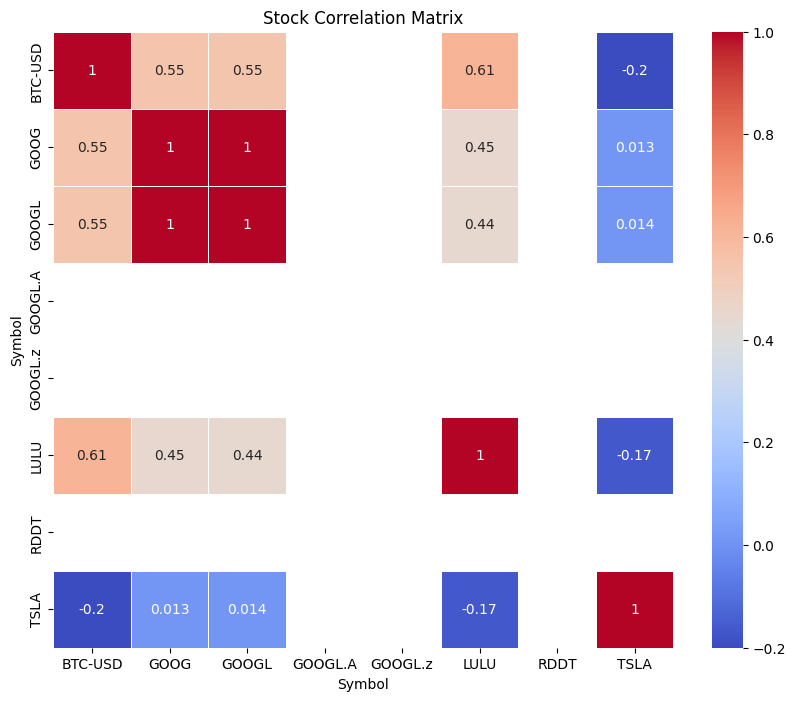

In [12]:
# Main execution
if __name__ == "__main__":
    csv_path = './res/stocks.csv'
    df = load_and_prepare_data(csv_path)
    biggest_move_report, avg_percent_change = generate_reports(df)
    df_list = [biggest_move_report, avg_percent_change]
    table_names = ['biggest_move_report', 'avg_percent_change_per_stock']
    db_path = './database/stock_analysis.db'
    save_to_database(df_list, table_names, db_path)
    visualize_stock_correlation(df,'./correlation_matrix/day1.png')

#### Observation:
Lack of entries for GOOGL.A, GOOGL.z and RDDT in the stocks.csv dataset caused NaN value in Daily Percentage Change for these stocks, hence there's no correlation between them and other stocks
